# Preparation

In [23]:
import os
import sys

import pandas as pd

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning
from nlp import tokenize_doc

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=True, categories_reduced=True
)
# jobs.head()

In [24]:
jobs = jobs[
    (jobs["Description"] != "Nicht stepstone")
    & (jobs["Description"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Description"] != "")
    & (jobs["Profile"] != "")
	& (jobs["Gehalt_min_yearly"]).notna()
]
texts = jobs["Titel"] + " " + jobs["Description"] + " " + jobs["Profile"]

# Preprocessing

In [25]:
import pickle

if os.path.isfile("../data/lemmatized_only_ds.pkl"):
    with open("../data/lemmatized_only_ds.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas
        
    with open("../data/lemmatized_only_ds.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 2000 documents
500/2000
1000/2000
1500/2000
2000/2000


In [26]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('data', 2581),
 ('business', 1988),
 ('analyst', 1972),
 ('bereich', 1877),
 ('team', 1812),
 ('erfahrung', 1742),
 ('analyse', 1726),
 ('kenntnis', 1632),
 ('abgeschlossen', 1292),
 ('studium', 1271)]

In [29]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import numpy as np


def vec_lsa(documents):
    # Feature Extraction using TfidfVectorizer

    vectorizer = TfidfVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        min_df=5,
        max_df=1.0
    )

    t0 = time()
    X_tfidf = vectorizer.fit_transform(documents)

    print(f"vectorization done in {time() - t0:.3f} s")
    print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

    print(f"Sparsity: {X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

    # Performing dimensionality reduction using LSA
    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
    t0 = time()
    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()

    print(f"LSA done in {time() - t0:.3f} s")
    print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

    return vectorizer, X_tfidf, lsa, X_lsa

In [30]:
vectorizer_all, X_tfidf_all, lsa_all, X_lsa_all = vec_lsa(lemmas)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


vectorization done in 0.170 s
n_samples: 2000, n_features: 4446
Sparsity: 0.019
LSA done in 2.414 s
Explained variance of the SVD step: 31.1%


# Clustering with kmeans

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def cluster_means(n, X_lsa):
    t0 = time()

    inertias = {}
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, max_iter=100, n_init=1, random_state=1)

        kmeans.fit(X_lsa)
        inertias[k] = kmeans.inertia_

    print(f"Clustering done in {time() - t0:.3f} s")

    plt.figure()
    plt.plot(inertias.keys(), inertias.values())
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.show()


def terms_per_cluster(lsa, vectorizer, kmeans, n):
    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(n):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :20]:
            print(f"{terms[ind]} ", end="")
        print()

Clustering done in 4.829 s


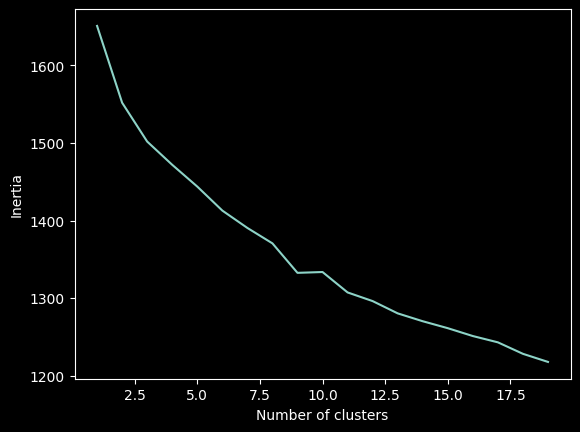

In [31]:
cluster_means(20, X_lsa_all)

# Top terms per Cluster

In [41]:
cluster_count=9
kmeans_all = KMeans(
    n_clusters=cluster_count,
    max_iter=100,
    n_init=1,
	random_state=2
)


kmeans_all.fit(X_lsa_all)

terms_per_cluster(lsa_all, vectorizer_all, kmeans_all, cluster_count)

Cluster 0: wesentlich datum sales tiefgründig sein erfolgreich inputgeber businesssprach zeitgleich mehrdimensional visualisierungsplattform stepston wachstumsfeld kundenperspektive zielbild datenverständnis aggregation parameter verknüpfung mysql 
Cluster 1: kreditanalyst bank kenntnis erstellung office bereich m analyse hoch risiko abgeschlossen insbesondere rahmen analytisch überwachung gewerblich prüfung berufserfahrung studium umgang 
Cluster 2: sein data datum analytic analyse marketing bereich power kenntnis business tool erfahrung dashboard datenanalyse sql report analyst analytisch team digital 
Cluster 3: financial risk experience finance analysis skills investment business management credit project strong supporen degree work processes analytical team knowledg well 
Cluster 4: business anforderung fachlich prozeß agil technisch team erfahrung analyst kunde lösung projekt fachbereich arbeiten vergleichbar unser studium umsetzung bereich bringen 
Cluster 5: controlling sap ers

Wir stellen fest, dass wir Jobs in Deutsch und Englisch haben. Wir wollen unsere Analyse aber auf deutsche Jobs beschränken. Also wollen wir nicht mehr mit Dokumenten aus Cluster 6 arbeiten

In [33]:
labels = kmeans_all.labels_

indeces_cluster_german = np.where(labels != 6)[0]

german_docs = [lemmas[i] for i in indeces_cluster_german]
print(f"{len(german_docs)} german documents")

1848 german documents


In [34]:
vectorizer_ger, X_tfidf_ger, lsa_ger, X_lsa_ger = vec_lsa(german_docs)

vectorization done in 0.151 s
n_samples: 1848, n_features: 3871
Sparsity: 0.021


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LSA done in 0.697 s
Explained variance of the SVD step: 31.9%


Clustering done in 2.703 s


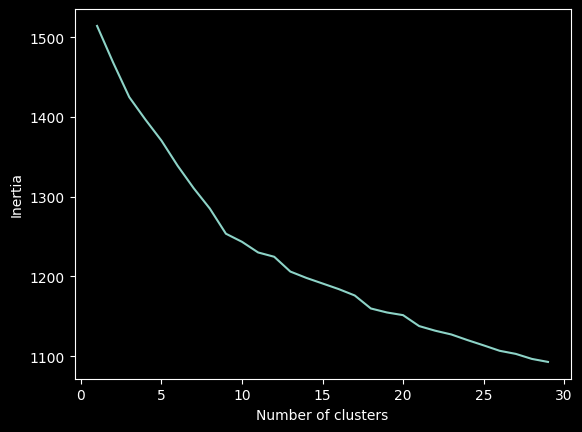

In [35]:
cluster_means(30, X_lsa_ger)

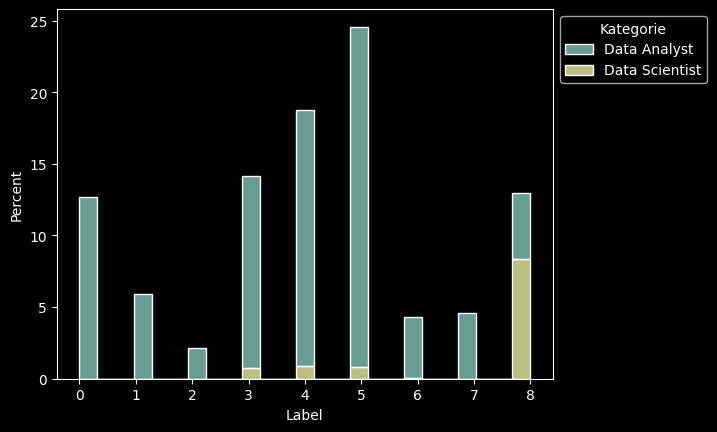

In [39]:
import seaborn as sns

kmeans_ger = KMeans(
    n_clusters=9,
    max_iter=100,
    n_init=1,
	random_state=2
)

kmeans_ger.fit(X_lsa_ger)

labels = kmeans_ger.labels_

df_eval = pd.DataFrame(
    {"Label": labels, "Kategorie": jobs.iloc[indeces_cluster_german, 18]}
)

# display(df_eval.groupby("Kategorie").value_counts(subset=["Label"], normalize=True))
by_label = df_eval.groupby("Label").value_counts(subset=["Kategorie"], normalize=True)

ax = sns.histplot(
    data=df_eval, x="Label", hue="Kategorie", multiple="stack", stat="percent"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# terms_per_cluster(lsa, vectorizer, kmeans, 2)

In [37]:
# jobs einmal nach cluster und einmal nach kategorie aufteilen
# für jede gruppe training split mit GridSearchCV
# gehalt vorhersagen